In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = 'all'
plt.style.use('dark_background')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
def extract_numericals(df):
    """Extract floats and replace missing values w median"""
    df_flt = df.select_dtypes(include='float64')
    df_flt = df_flt.fillna(value=df_flt.median())
    return df_flt

In [5]:
def one_hot_encode(series):
    """Return series encoded OneVsAll"""
    le = LabelEncoder()
    le.fit(series)
    classes = le.classes_
#     print('LE classes', classes)
    series_le = le.transform(series)
    
    oh = OneHotEncoder(sparse=False)
    feat_le = series_le.reshape(-1, 1)
    oh.fit(feat_le)
#     print('OH feats', oh.active_features_)
    feat_oh = oh.transform(feat_le)
    # Avoid dummy trap
    feat_oh = feat_oh[:, -2]
#     print('shape:', feat_oh.shape)
    return feat_oh

In [6]:
def show_pearson(df):
    """Display correlation matrix of dataset"""
    corr_mat = df.corr()
    display(corr_mat)
    sns.heatmap(corr_mat)
    return corr_mat

In [16]:
def score_logistic_regression(df, df_tst):
    """Fit logistic regressor and evalute metrics"""
    # Get design matrix and target
    X = df.drop(columns=['Survived']).values
    X_tst = df_tst.drop(columns=['Survived']).values
    y = df['Survived'].values
    y_tst = df_tst['Survived'].values
    # Fit logistic regressor to training data
    lr = LogisticRegression()
    lr = lr.fit(X, y)
    # Collect predictions
    y_pred = lr.predict(X)
    y_pred_tst = lr.predict(X_tst)
    scores = precision_recall_fscore_support(y, y_pred, average='binary')
    scores_tst = precision_recall_fscore_support(y_tst, y_pred_tst, average='binary')
    return scores, scores_tst

In [21]:
def generate_score(df):
    while True:
        df_trn, df_tst = train_test_split(df, test_size = .2, shuffle=True)
        # Extract floating point quantities and fill missing values
        df_trn_end = extract_numericals(df_trn)
        df_tst_end = extract_numericals(df_tst)
        # OneHotEncoding of Sex
        df_trn_end['Sex'] = one_hot_encode(df_trn['Sex'])
        df_tst_end['Sex'] = one_hot_encode(df_tst['Sex'])
        # Add target
        df_trn_end['Survived'] = df_trn['Survived']
        df_tst_end['Survived'] = df_tst['Survived']
        # Evaluate LogisticRegressor
        yield score_logistic_regression(df_trn_end, df_tst_end)

In [32]:
df = pd.read_csv('train.csv')
res = [next(generate_score(df)) for _ in range(200)]

In [61]:
ps_trn = []
rs_trn = []
fs_trn = []

ps_tst = []
rs_tst = []
fs_tst = []

for instance in res:
    res_trn, res_tst = instance
    p_trn, r_trn, f_trn, _ = res_trn
    p_tst, r_tst, f_tst, _ = res_tst
    ps_trn.append(p_trn)
    rs_trn.append(r_trn)
    fs_trn.append(f_trn)
    ps_tst.append(p_tst)
    rs_tst.append(r_tst)
    fs_tst.append(f_tst)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e7c4be0>,
      dtype=object)

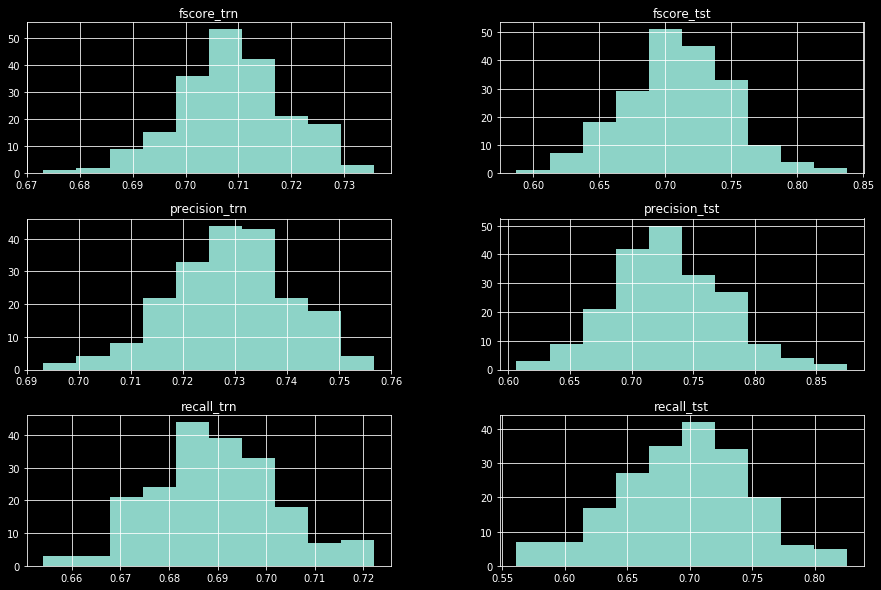

In [74]:
scores = pd.DataFrame({
    'precision_trn': ps_trn,
    'recall_trn': rs_trn,
    'fscore_trn': fs_trn,
    'precision_tst': ps_tst,
    'recall_tst': rs_tst,
    'fscore_tst': fs_tst
})
scores.hist(figsize=(15, 10))